In [1]:
import import_ipynb as inb
import datetime as dt


import EMC_new 
from EMC_new import *




importing Jupyter notebook from EMC_new.ipynb


No handles with labels found to put in legend.
No handles with labels found to put in legend.


/home/jbane/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


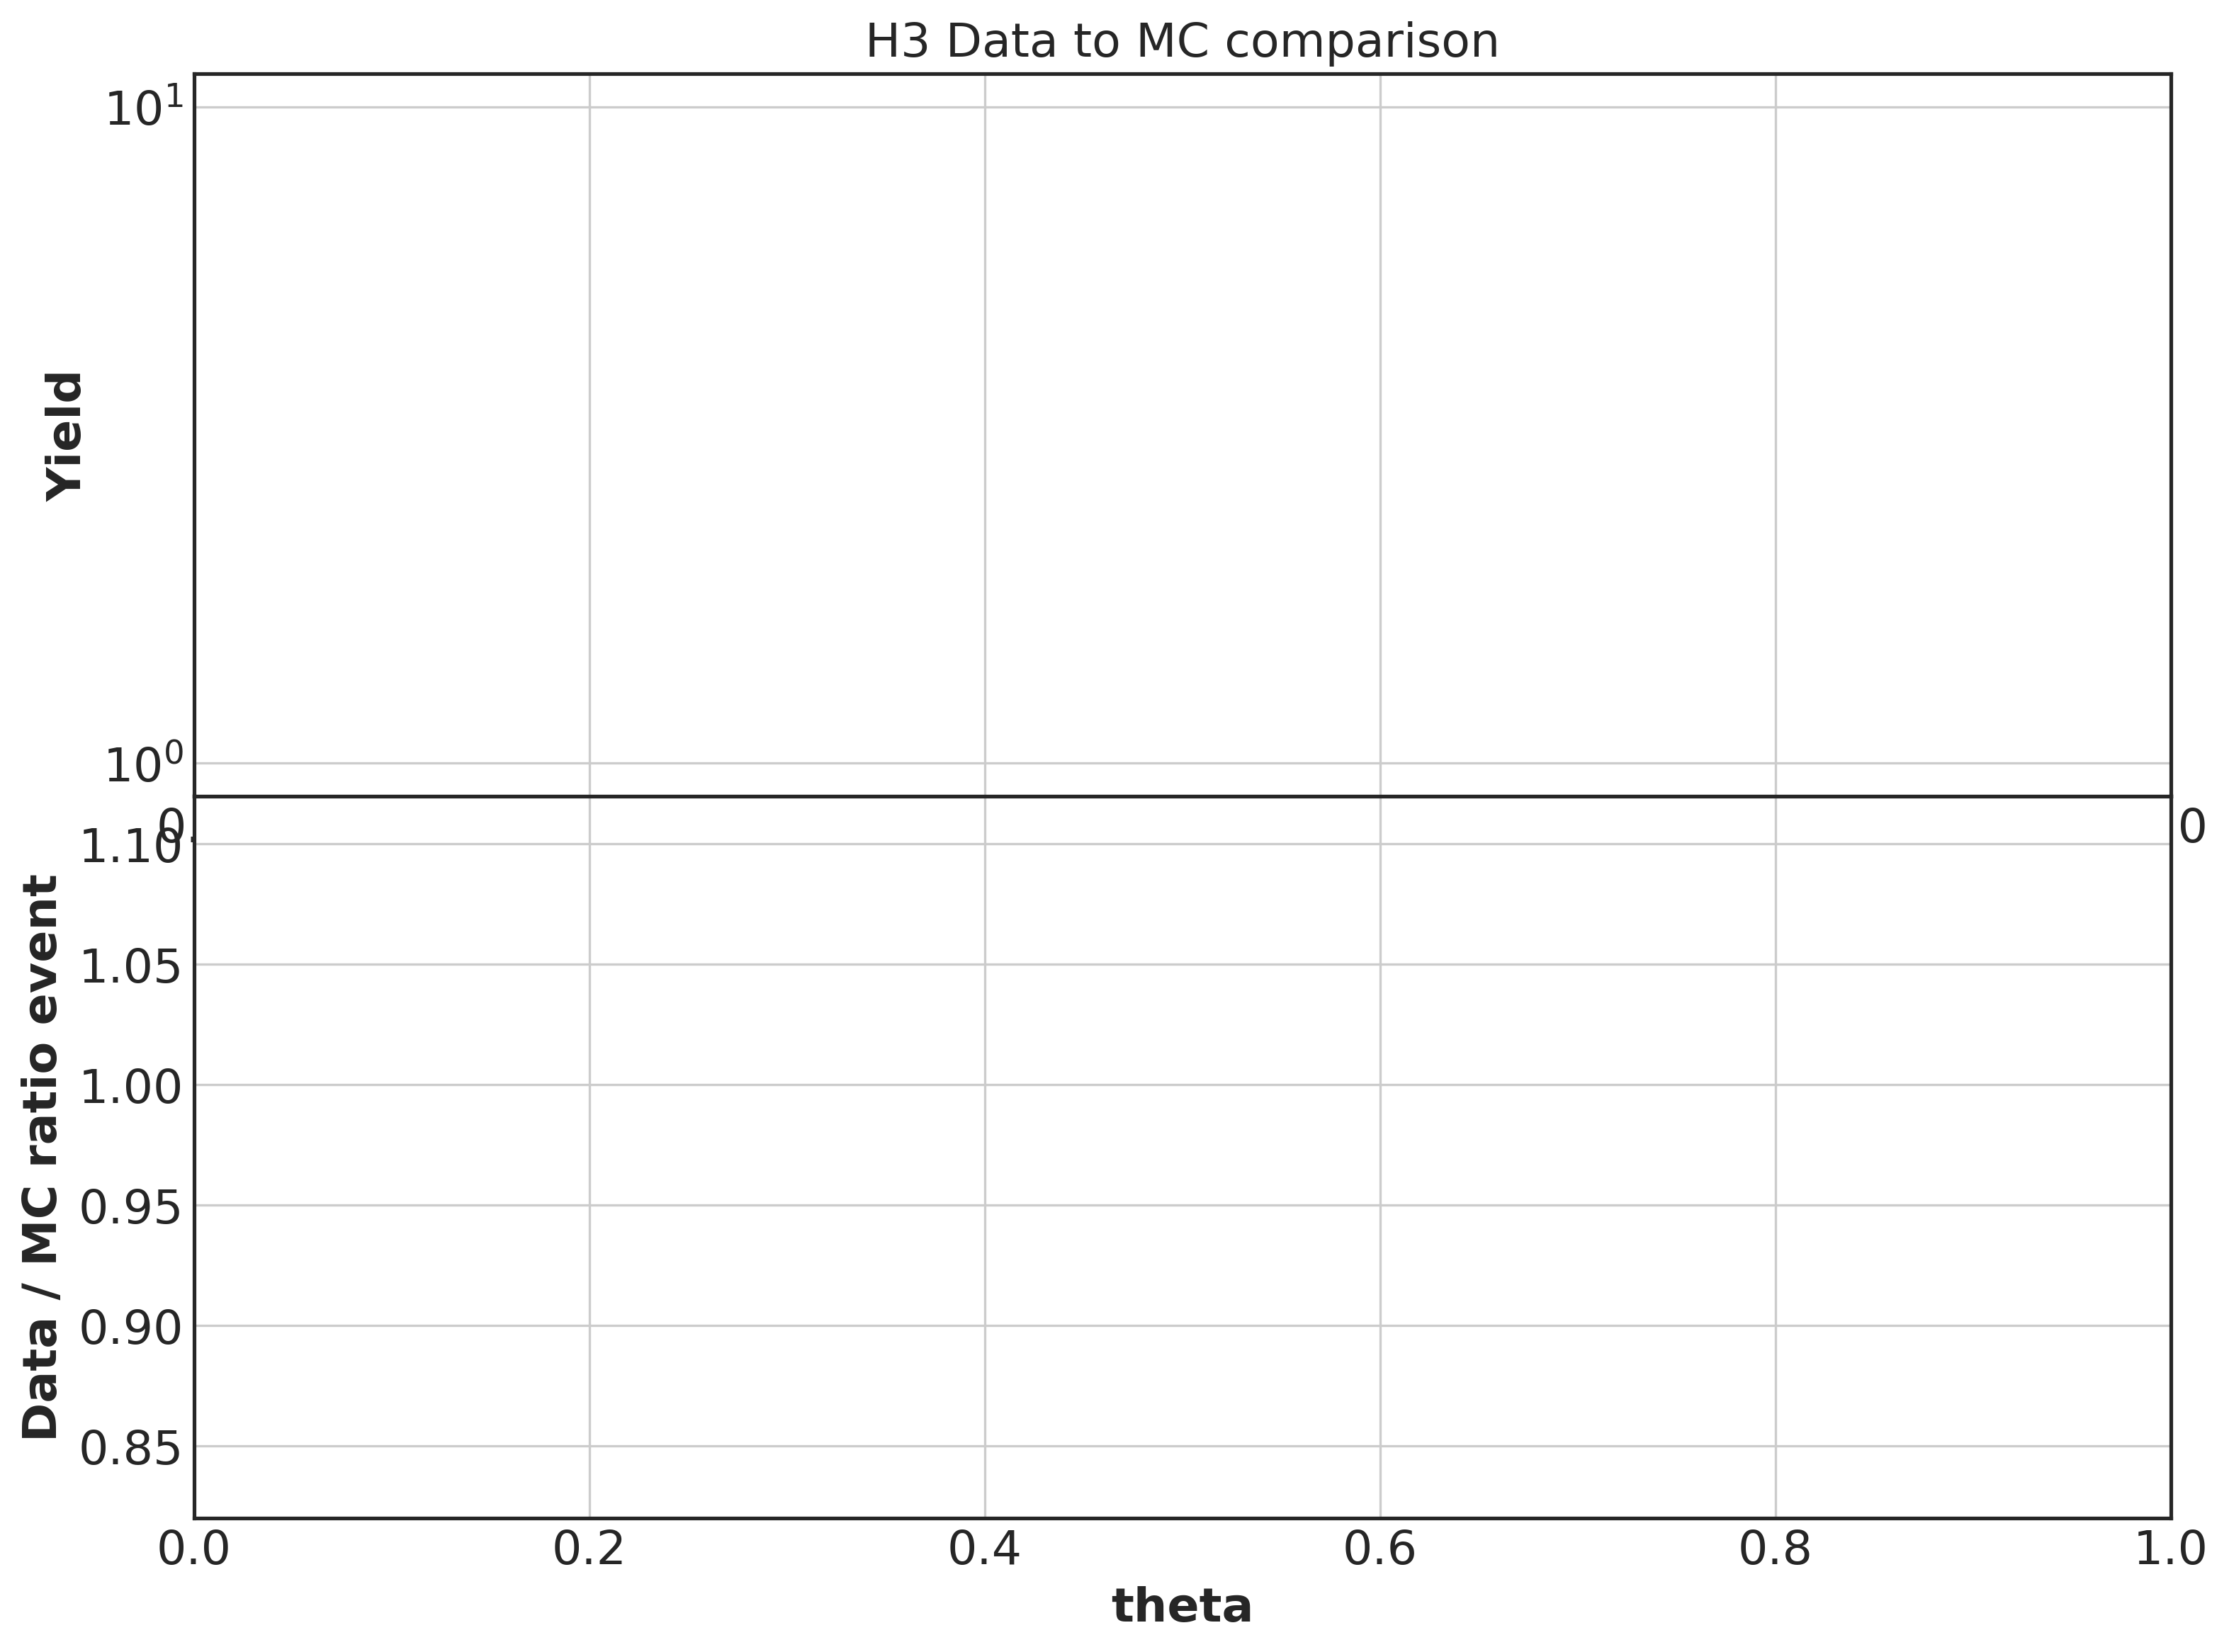

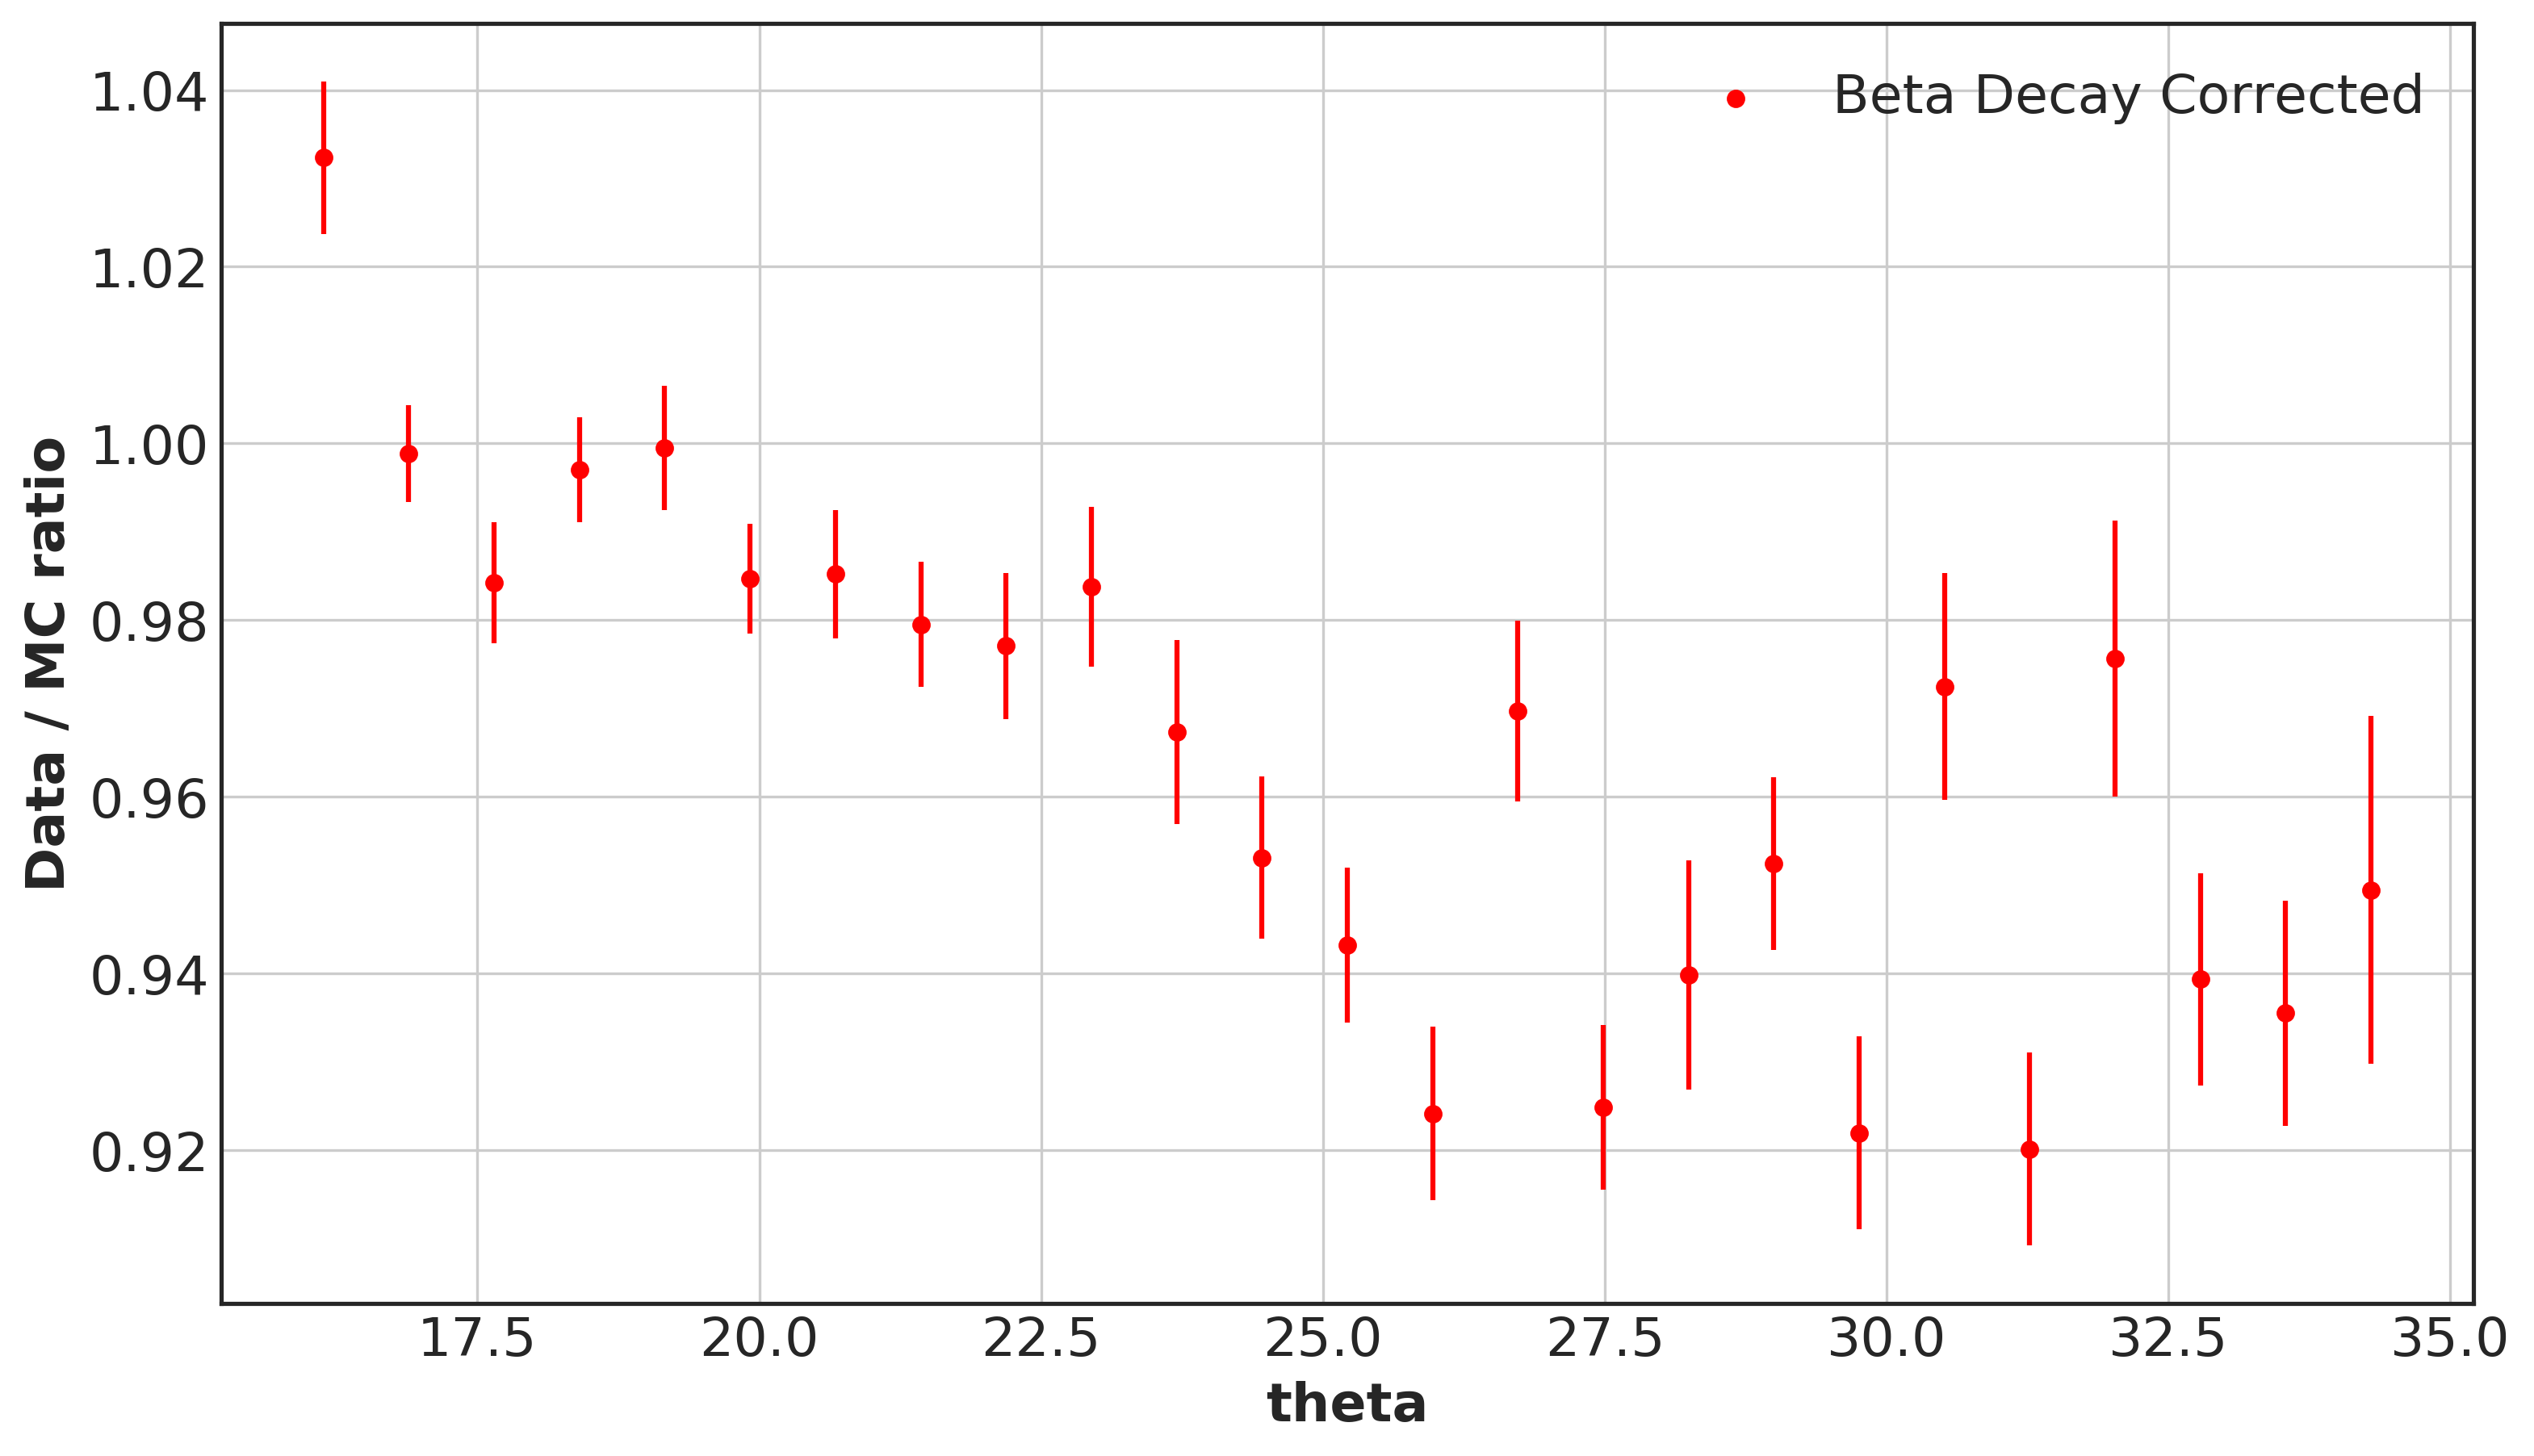

In [2]:
okin=""
b="30"
xaxis="theta"

H3_e10=Yield("H3",b,"all",xaxis,okin)

H3B10=Born(H3_e10[0],"H3")
H3eFull_10=YieldFull(H3B10,xaxis)

In [4]:
H3_e10

({1:      theta       Ne     Yield     Error       xbj  Stat Err         Lumin  \
  1  16.1350  18086.0  0.001575  0.000017  0.189572  0.000012  1.297912e+07   
  2  16.8917  40230.0  0.003498  0.000032  0.201752  0.000017  1.297912e+07   
  3  17.6483  31702.0  0.002751  0.000026  0.220105  0.000015  1.297912e+07   
  4  18.4050  25637.0  0.002221  0.000022  0.239249  0.000014  1.297912e+07   
  
         Lumin Err  Thickness Err per  Dens Cor. Err per  ...  kin  \
  1  142754.052117              0.968              0.002  ...    1   
  2  142754.052117              0.968              0.002  ...    1   
  3  142754.052117              0.968              0.002  ...    1   
  4  142754.052117              0.968              0.002  ...    1   
  
     D-mc stat error  D-mc error noeff      sigma     sigmaR   C_cor  \
  1         0.008600          0.010946  16.121169  18.184794  1.0003   
  2         0.005482          0.009042  16.108685  18.163766  1.0003   
  3         0.005971          

No handles with labels found to put in legend.
No handles with labels found to put in legend.


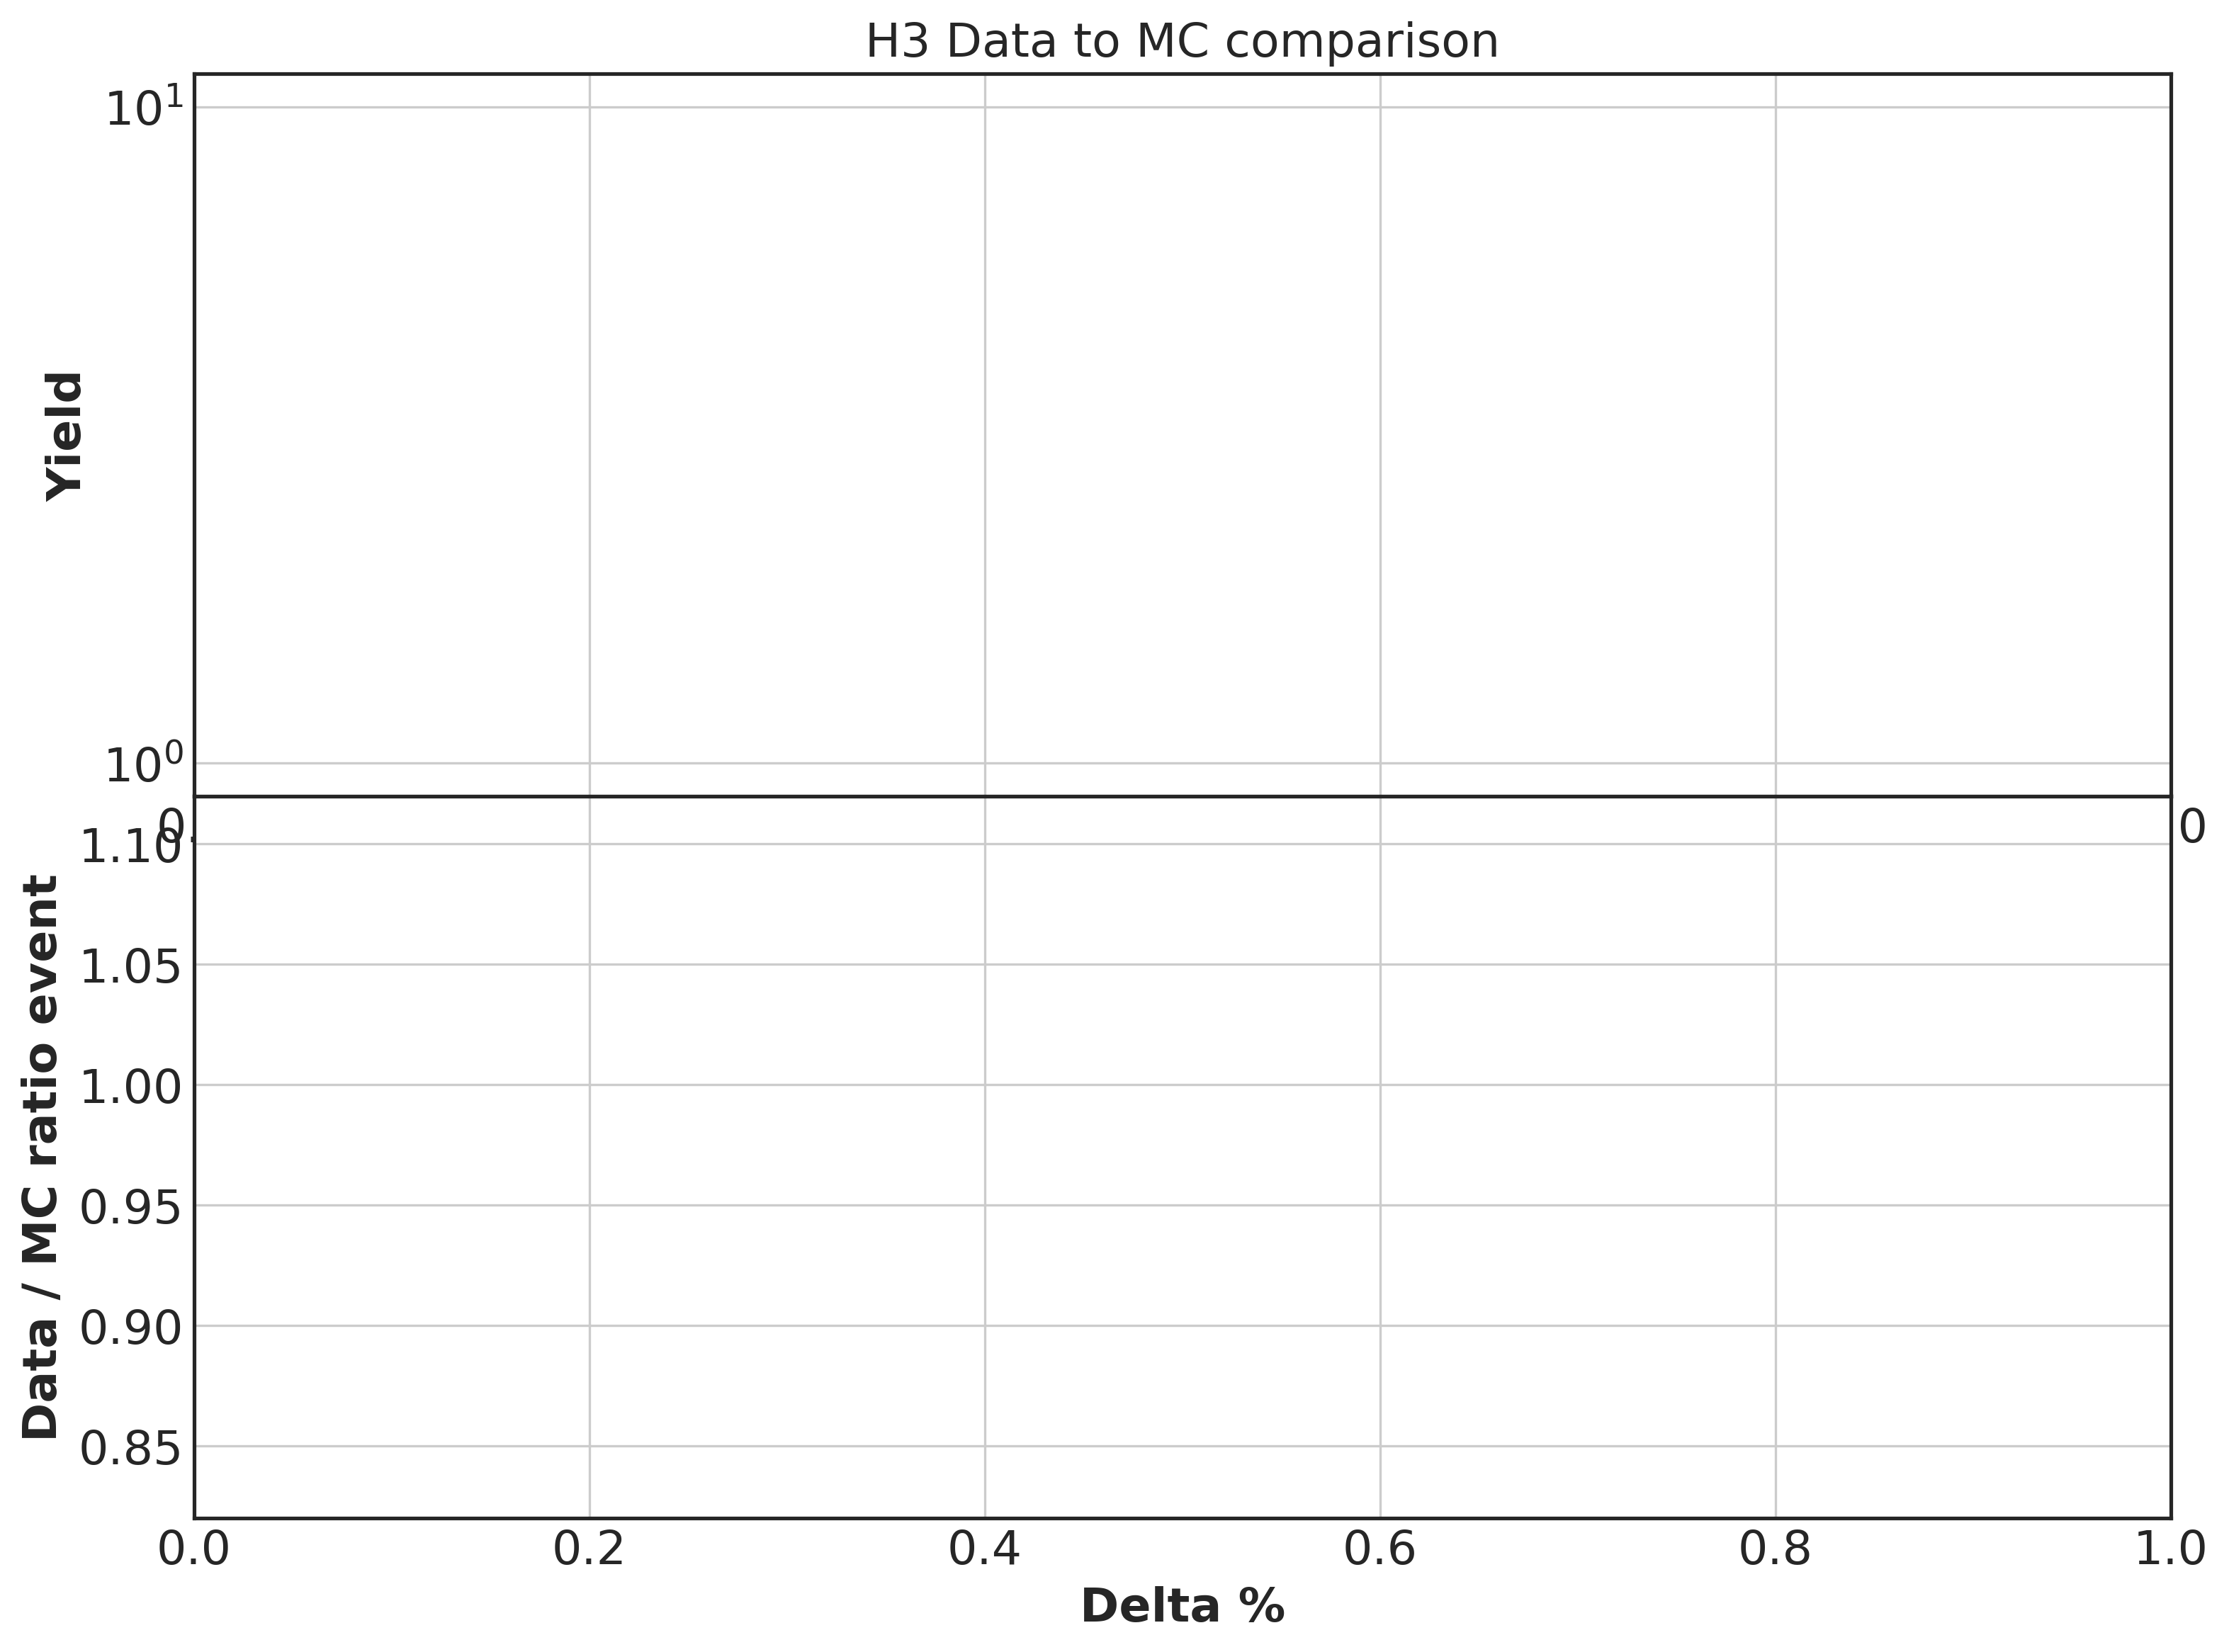

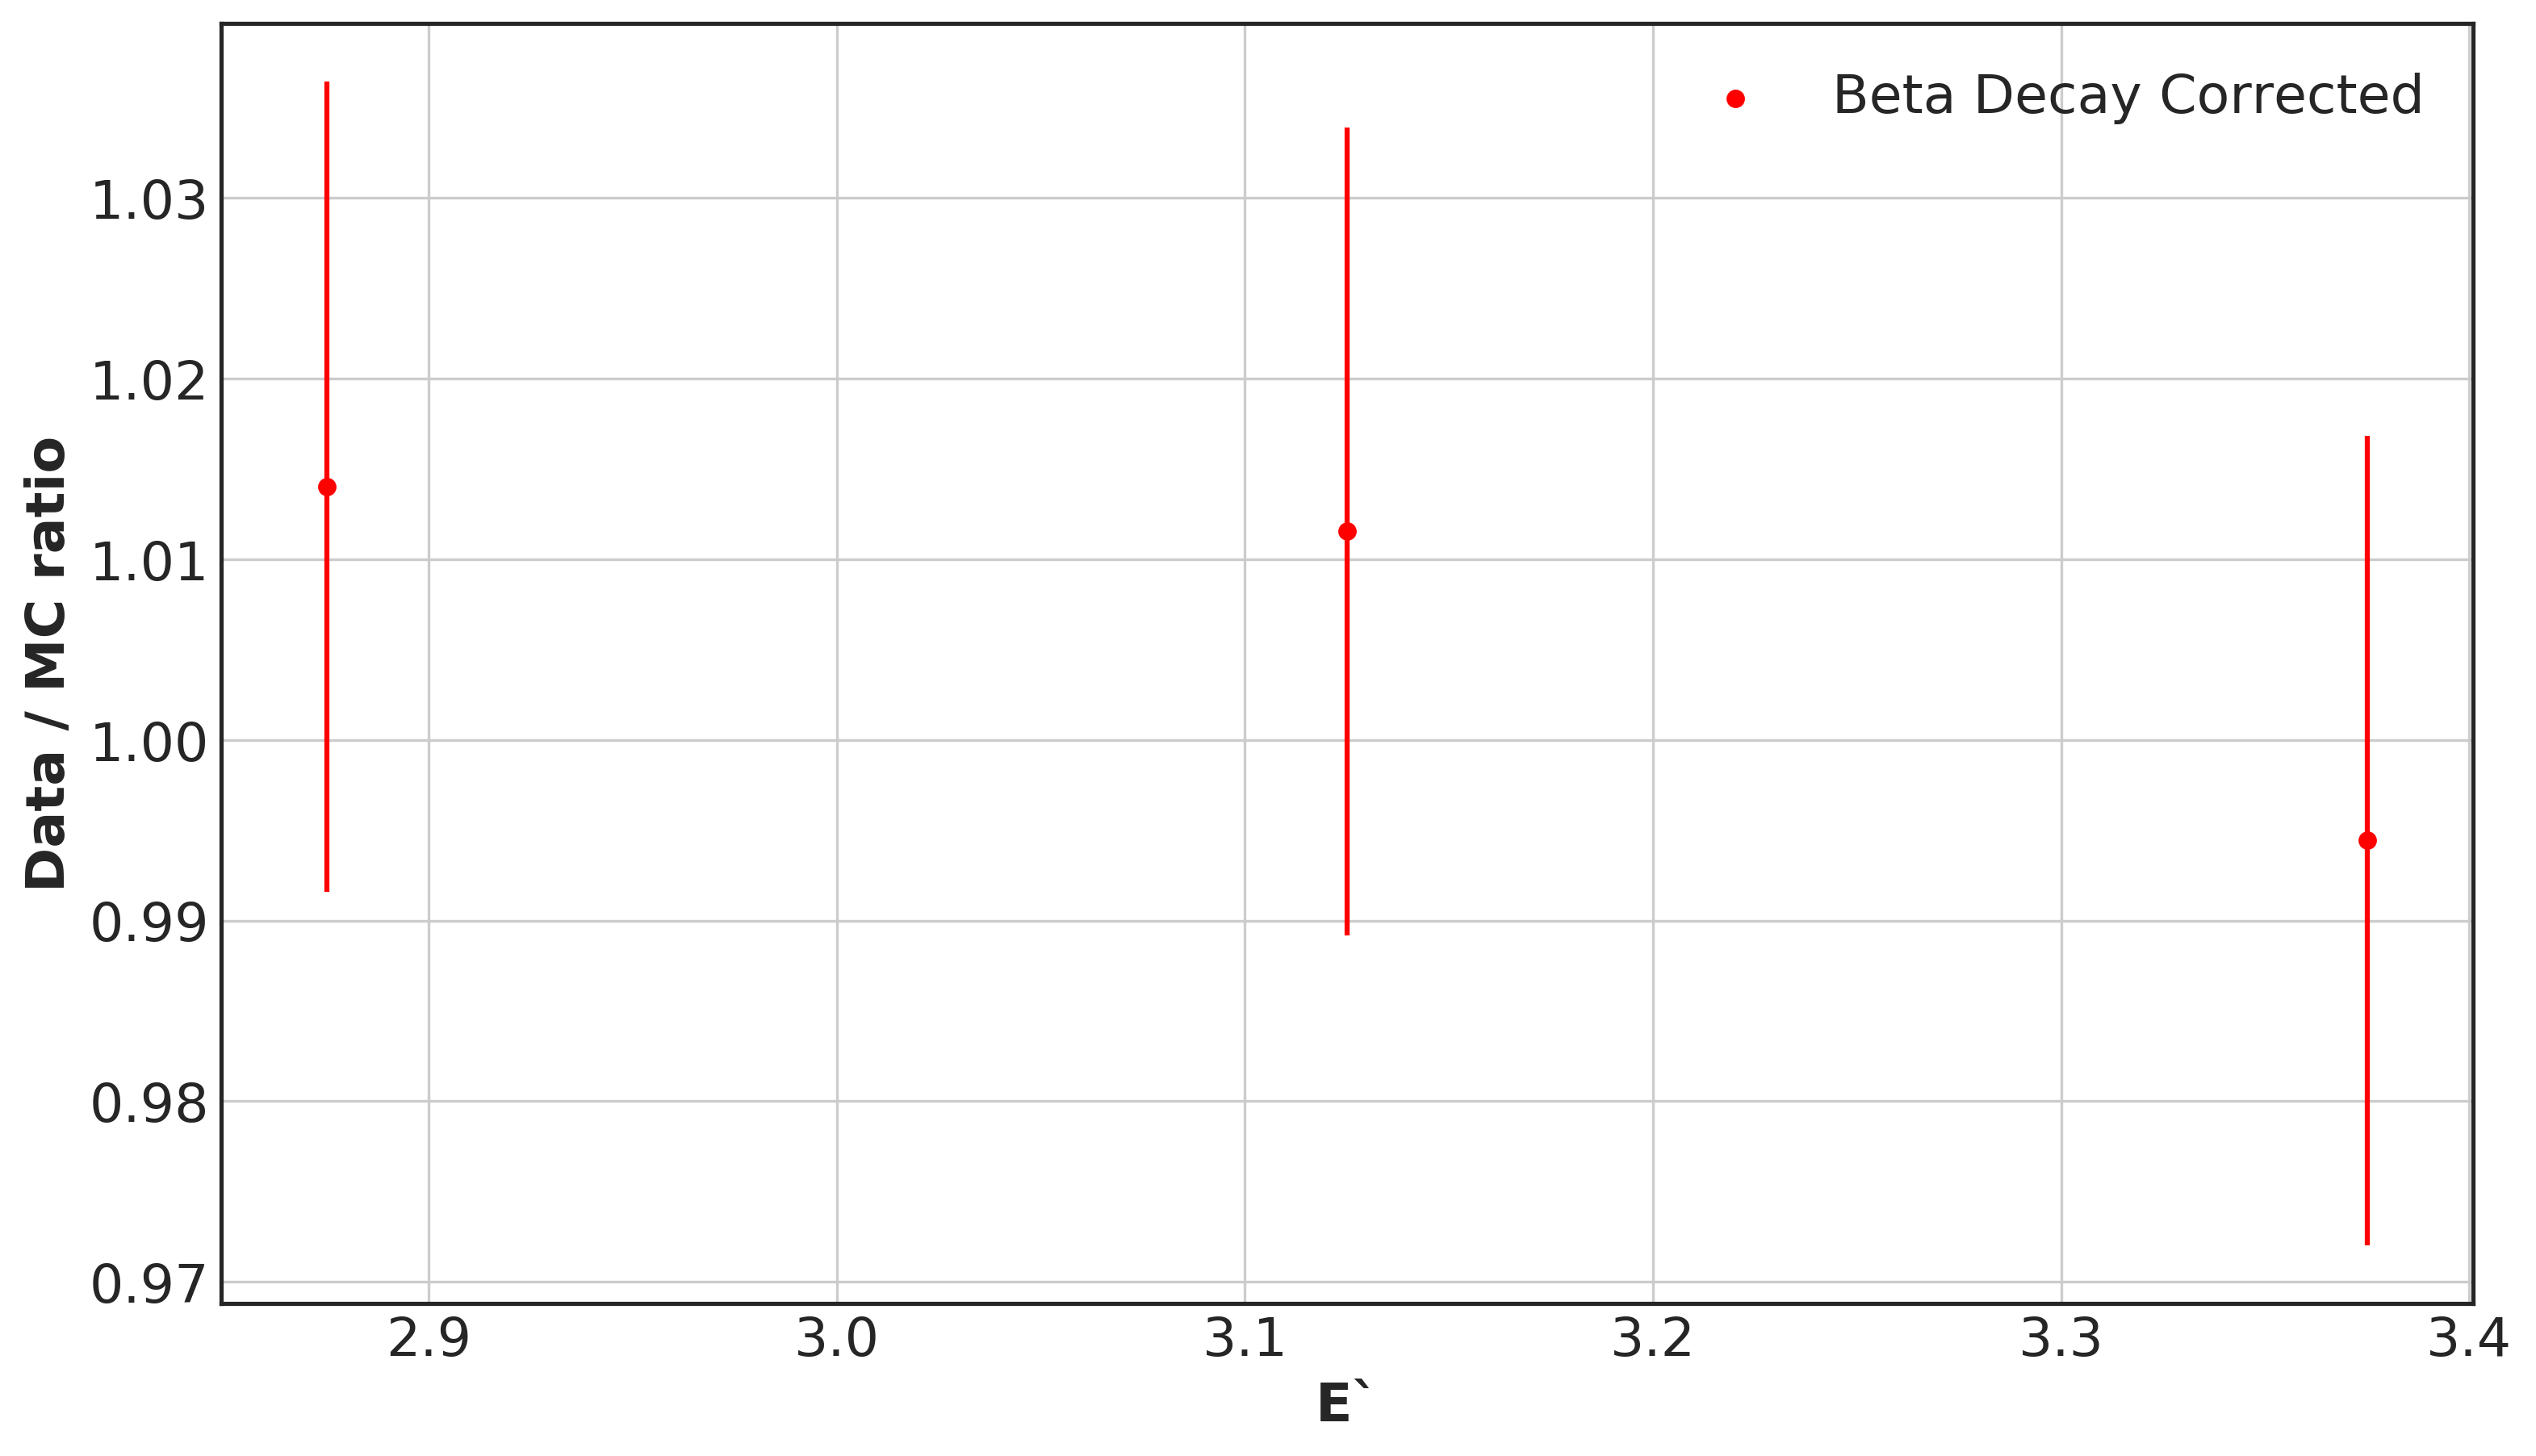

In [5]:
okin=""
b="30"
xaxis="E`"

H3_e10=Yield("H3",b,"all",xaxis,okin)

H3B10=Born(H3_e10[0],"H3")
H3eFull_10=YieldFull(H3B10,xaxis)

In [9]:
whatangle(1)

17.577

AttributeError: 'tuple' object has no attribute 'plot'